In [1]:
!pip install kaggle

In [2]:
!mkdir -p /root/.kaggle
!scp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d phucthaiv02/butterfly-image-classification

Dataset URL: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification
License(s): CC0-1.0


In [5]:
!rm -rf /content/butterfly
!unzip butterfly-image-classification.zip -d butterfly

Streaming output truncated to the last 5000 lines.
  inflating: butterfly/train/Image_2348.jpg  
  inflating: butterfly/train/Image_2349.jpg  
  inflating: butterfly/train/Image_235.jpg  
  inflating: butterfly/train/Image_2350.jpg  
  inflating: butterfly/train/Image_2351.jpg  
  inflating: butterfly/train/Image_2352.jpg  
  inflating: butterfly/train/Image_2353.jpg  
  inflating: butterfly/train/Image_2354.jpg  
  inflating: butterfly/train/Image_2355.jpg  
  inflating: butterfly/train/Image_2356.jpg  
  inflating: butterfly/train/Image_2357.jpg  
  inflating: butterfly/train/Image_2358.jpg  
  inflating: butterfly/train/Image_2359.jpg  
  inflating: butterfly/train/Image_236.jpg  
  inflating: butterfly/train/Image_2360.jpg  
  inflating: butterfly/train/Image_2361.jpg  
  inflating: butterfly/train/Image_2362.jpg  
  inflating: butterfly/train/Image_2363.jpg  
  inflating: butterfly/train/Image_2364.jpg  
  inflating: butterfly/train/Image_2365.jpg  
  inflating: butterfly/train/Im

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [7]:
data = pd.read_csv("butterfly/Training_set.csv")

In [ ]:
print("Number of training:",data.shape[0])
print("Columns: ", data.columns)

Number of training: 6499
Columns:  Index(['filename', 'label'], dtype='object')


In [ ]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6499 non-null   object
 1   label     6499 non-null   object
dtypes: object(2)
memory usage: 101.7+ KB


,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [8]:
def to_lower(col):
    return col.lower()


In [9]:
data["label"] = data["label"].apply(to_lower)

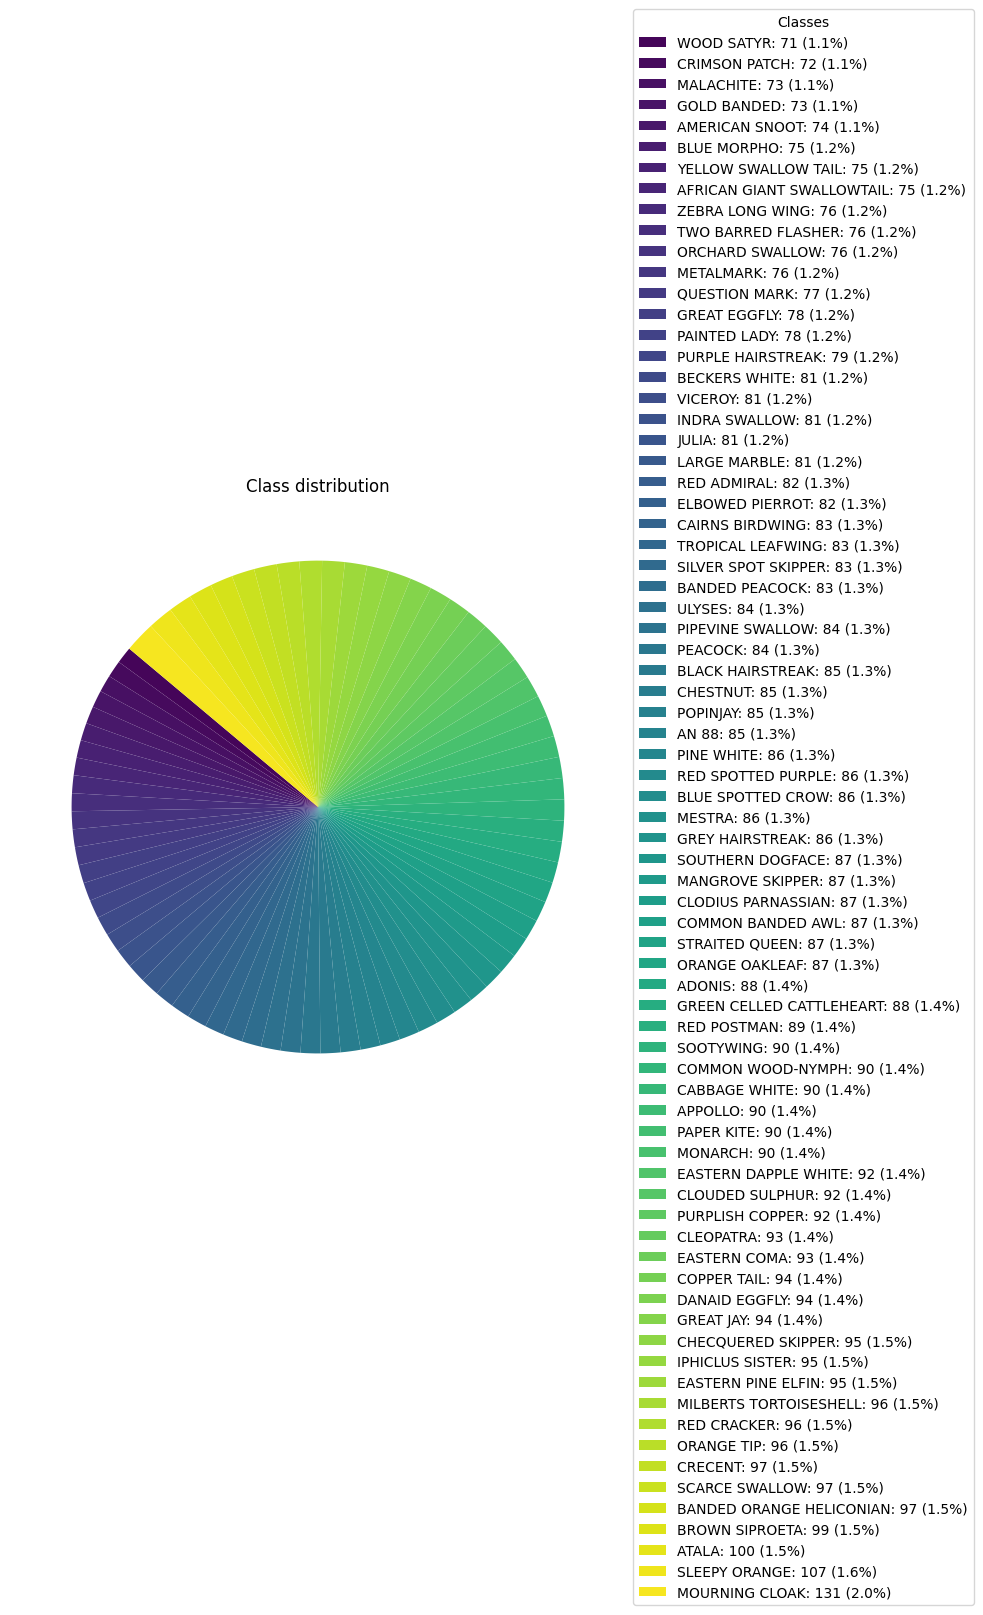

In [ ]:
class_counts = data['label'].value_counts().sort_values(ascending=True)

colors = sns.color_palette("viridis", len(class_counts))

# Создать круговую диаграмму без подписей
fig, ax = plt.subplots(figsize=(8, 8))
wedges, _ = ax.pie(
    class_counts,
    labels = None,
    startangle=140,
    colors=colors
)

# Создать легенду с названиями классов и процентами
legend_labels = [f"{label}: {count} ({count / class_counts.sum() * 100:.1f}%)"
                 for label, count in class_counts.items()]

ax.legend(wedges, legend_labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title('Class distribution')
plt.show()

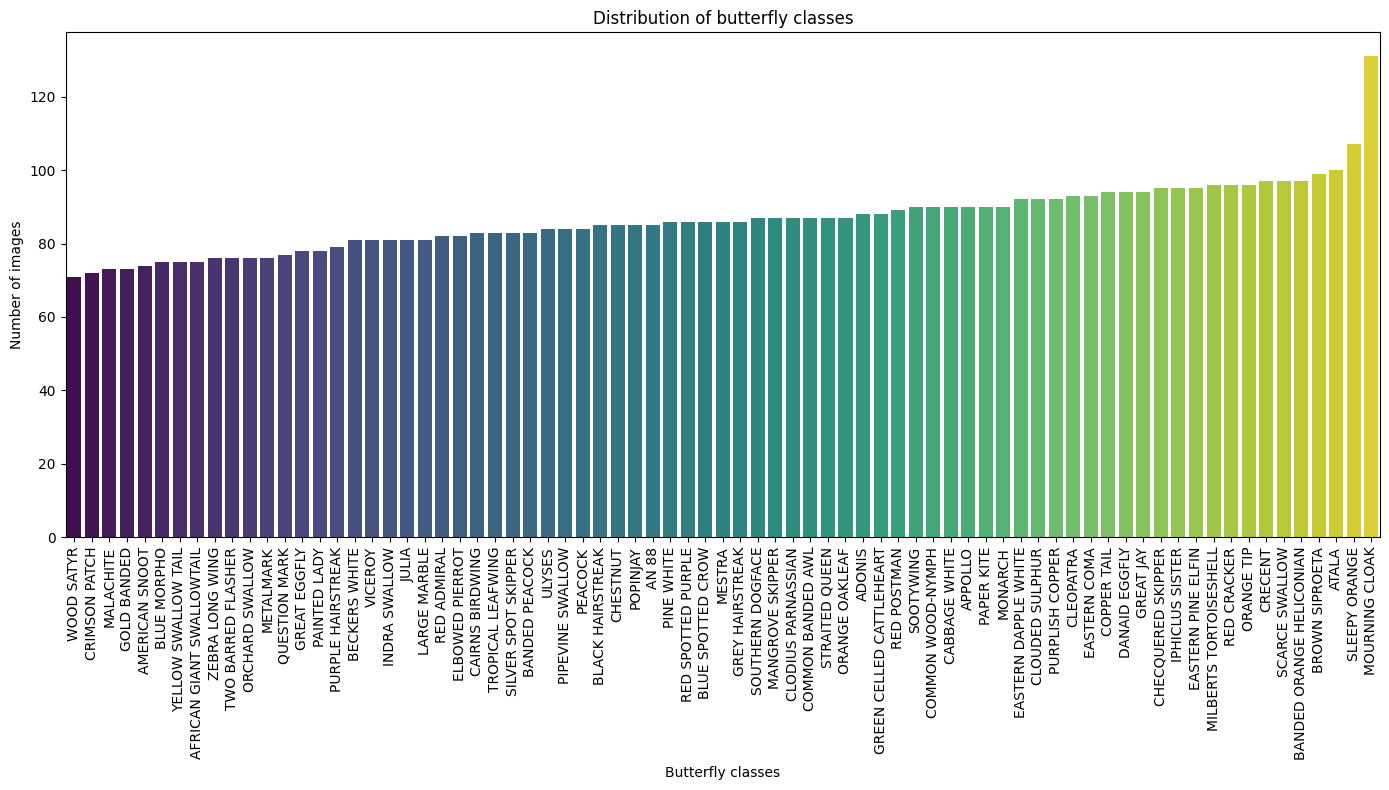

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette="viridis", legend=False)
plt.title('Distribution of butterfly classes')
plt.xlabel('Butterfly classes')
plt.ylabel('Number of images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
image_dir = "/content/butterfly/train"

sample_img = data.sample(30, random_state=42)

fig, axes = plt.subplots(5, 6, figsize=(18, 18))

for i, (index, row) in enumerate(sample_img.iterrows()):
  img_path = os.path.join(image_dir, row['filename'])
  img = load_img(img_path, target_size=(150, 150))
  img_array = img_to_array(img) / 255.0

  ax = axes[i // 6, i % 6]
  ax.imshow(img_array)
  ax.set_title(f"Class: {row['label']}")
  ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import random

In [11]:
def check_gpu():
    if tf.config.list_physical_devices('GPU'):
        print("GPU is available")
    else:
        print("No GPU found, using CPU")

check_gpu()

GPU is available


In [12]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [13]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [15]:
image_size = (150,150)
batch_size = 32
epochs = 50

In [16]:
train_data = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='/content/butterfly/train',
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

val_data = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='/content/butterfly/train',
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


In [17]:
'''
model = tf.keras.Sequential([

    tf.keras.layers.InputLayer(shape=(150,150,3)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(data['label'].nunique(), activation='softmax')
])
'''

with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(data['label'].nunique(), activation='softmax')
    ])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 75)                  │          38,475 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,072,139 (72.75 MB)

 Trainable params: 19,072,139 (72.75 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

In [22]:
train_steps = int(train_data.n//batch_size)
val_steps = int(val_data.n//batch_size)

'''
history = model.fit(train_data,
          validation_data=val_data,
          epochs=epochs,
          steps_per_epoch=train_steps,
          validation_steps=val_steps)
'''

# Обучаем модель
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=val_steps
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.0375 - loss: 4.1687 - val_accuracy: 0.1648 - val_loss: 3.4411
Epoch 2/50
  1/162 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0938 - loss: 3.4306

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0938 - loss: 3.4306 - val_accuracy: 0.1703 - val_loss: 3.4286
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 33s 205ms/step - accuracy: 0.1674 - loss: 3.2434 - val_accuracy: 0.2656 - val_loss: 2.9075
Epoch 4/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2188 - loss: 2.9542 - val_accuracy: 0.2734 - val_loss: 2.8215
Epoch 5/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 42s 218ms/step - accuracy: 0.2779 - loss: 2.6395 - val_accuracy: 0.4000 - val_loss: 2.1872
Epoch 6/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3438 - loss: 2.1020 - val_accuracy: 0.4023 - val_loss: 2.1579
Epoch 7/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - accuracy: 0.3741 - loss: 2.2787 - val_accuracy: 0.4242 - val_loss: 2.1076
Epoch 8/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4062 - loss: 2.2225 - val_accuracy: 0.4187 - val_loss: 2.1196
Epoch 9/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.4238 - loss: 2.0480 - val_accuracy: 0

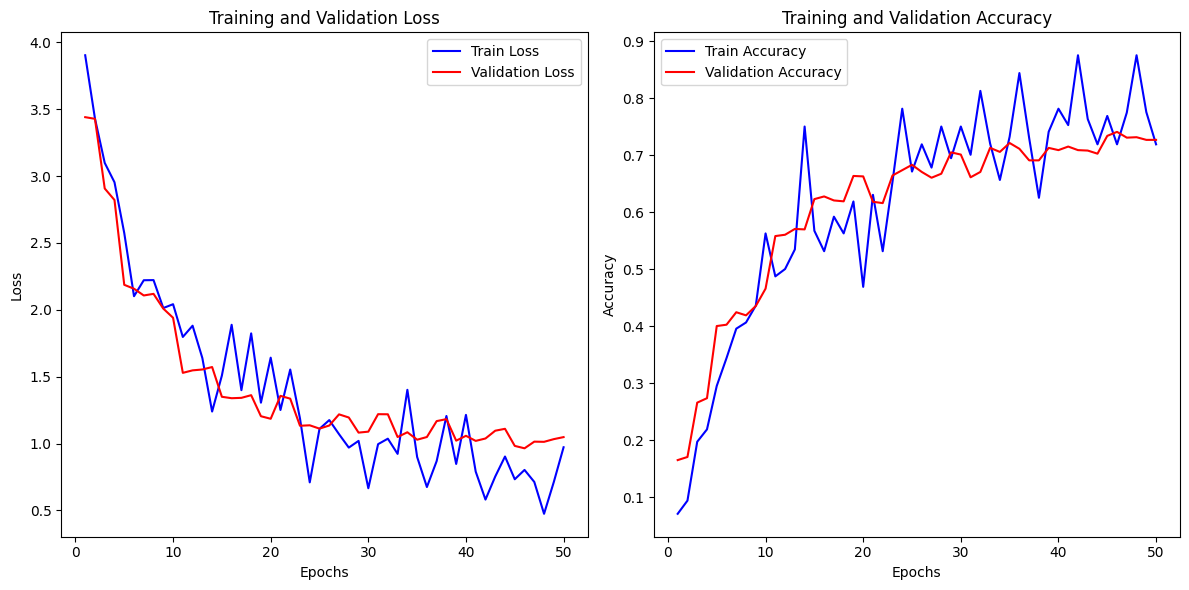

In [26]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

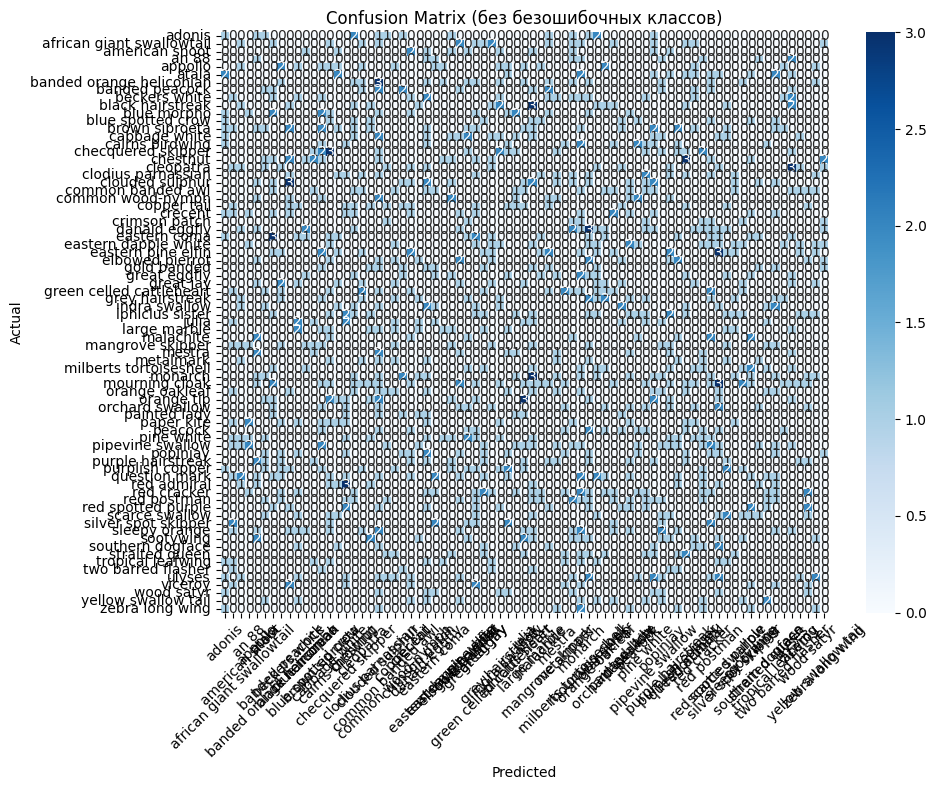

In [25]:
# Построение матрицы ошибок
# Получаем предсказания
y_pred = np.argmax(model.predict(val_data, verbose=0), axis=1)
y_true = val_data.classes
labels = list(val_data.class_indices.keys())

# Строим матрицу ошибок
cm = confusion_matrix(y_true, y_pred)

# Вычисляем, какие строки и столбцы содержат ошибки
mask = ~(np.eye(len(cm)) == cm)  # где не диагональ
error_rows = np.any(mask & (cm > 0), axis=1)  # строки с ошибками
error_cols = np.any(mask & (cm > 0), axis=0)  # столбцы с ошибками
valid_indices = np.where(error_rows | error_cols)[0]  # хотя бы в одном месте была ошибка

# Отфильтрованная матрица и классы
cm_filtered = cm[np.ix_(valid_indices, valid_indices)]
filtered_labels = [labels[i] for i in valid_indices]

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(cm_filtered, annot=True, fmt='d', cmap='Blues',
            xticklabels=filtered_labels, yticklabels=filtered_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (без безошибочных классов)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [27]:
num_samples = 25

# Вывод случайных 25 изображений с предсказаниями
random_indices = random.sample(range(len(val_data.filenames)), num_samples)

plt.figure(figsize=(15, num_samples * 3))

for i, idx in enumerate(random_indices):
    # Загружаем изображение
    img_path = os.path.join('/content/butterfly/train', val_data.filenames[idx])
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img) / 255.0
    img_array_exp = np.expand_dims(img_array, axis=0)

    # Предсказание и метки
    pred_class = np.argmax(model.predict(img_array_exp, verbose=0))
    true_class = y_true[idx]

    pred_label = labels[pred_class]
    true_label = labels[true_class]

    # Поиск изображения предсказанного класса
    pred_class_idx = next(
        (i for i, fname in enumerate(val_data.filenames) if val_data.classes[i] == pred_class),
        None
    )
    pred_img_path = os.path.join('/content/butterfly/train', val_data.filenames[pred_class_idx]) if pred_class_idx is not None else None

    # Поиск изображения истинного класса
    true_class_idx = next(
        (i for i, fname in enumerate(val_data.filenames) if val_data.classes[i] == true_class),
        None
    )
    true_img_path = os.path.join('/content/butterfly/train', val_data.filenames[true_class_idx]) if true_class_idx is not None else None

    # Отображение изображений: [Предсказанный] - [Целевой] - [Истинный]
    for j, path in enumerate([pred_img_path, img_path, true_img_path]):
        if path and os.path.exists(path):
            plot_img = load_img(path, target_size=image_size)
            plt.subplot(num_samples, 3, i * 3 + j + 1)
            plt.imshow(plot_img)
            plt.axis('off')
            if j == 0:
                plt.title(f'Pred Class:\n{pred_label}', color='blue')
            elif j == 1:
                color = 'green' if pred_class == true_class else 'red'
                plt.title(f'Input Image\nPred: {pred_label}\nTrue: {true_label}', color=color)
            else:
                plt.title(f'True Class:\n{true_label}', color='blue')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.